In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import os
%matplotlib inline

In [2]:
camcal_dir='./camera_cal/'
calimgs=os.listdir(camcal_dir)
#img=mpimg.imread(camcal_dir+calimgs[0])
#plt.imshow(img)

In [3]:
def grayscale(img, option=0):
    if option==0:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
    # Or use BGR2GRAY if you read an image with cv2.imread()
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for calimg in calimgs:
    img=mpimg.imread(camcal_dir+calimg)
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #mpimg.imsave(camcal_dir+'p_'+calimg, img)
    else:
        print('corners not found for '+calimg)


corners not found for calibration1.jpg
corners not found for calibration4.jpg
corners not found for calibration5.jpg


In [5]:
def cal_undistort(img, objpoints, imgpoints):
    gray = grayscale(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

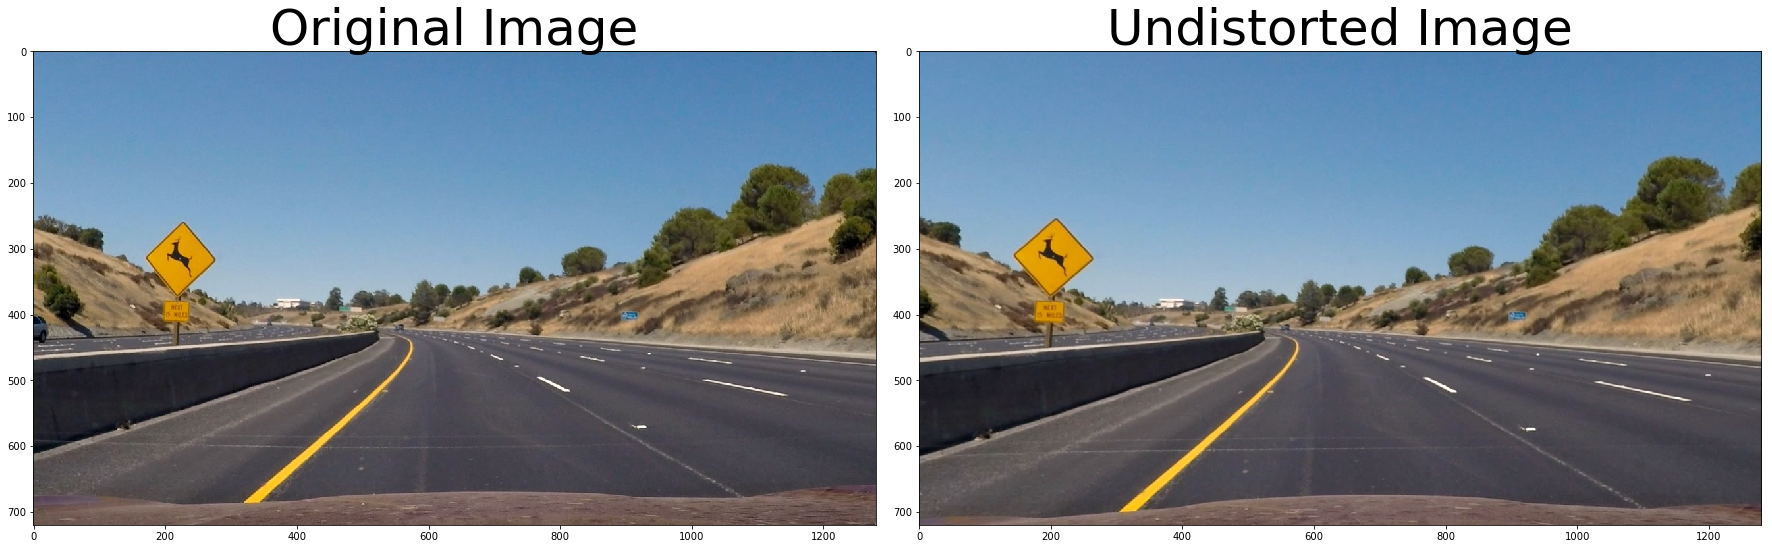

In [23]:
testimgs_dir='./test_images/'
testimgs=os.listdir(testimgs_dir)

img=mpimg.imread(testimgs_dir+testimgs[3])
#print(img.shape)
width=img.shape[1]
height=img.shape[0]
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

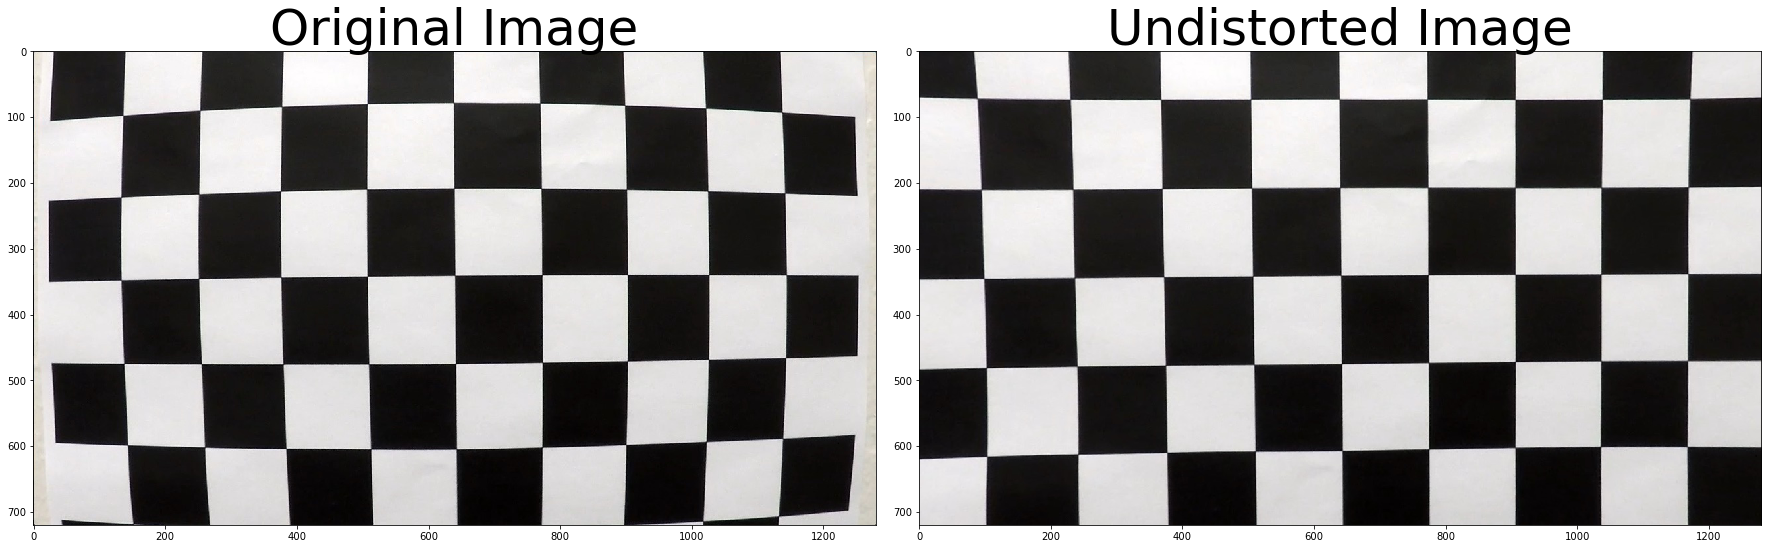

In [37]:
testimgs_dir='./camera_cal/'
testimgs=os.listdir(testimgs_dir)

img=mpimg.imread(testimgs_dir+testimgs[0])
#print(img.shape)
width=img.shape[1]
height=img.shape[0]
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

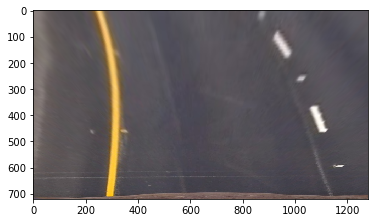

In [24]:
#src=np.float32([[0, height], [630, 520], [720, 520], [width, height]])
src=np.float32([[0, height], [530, 455], [750, 455], [width, height]])
dst=np.float32([[0, height], [0, 0], [width, 0], [width, height]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undistorted, M, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [25]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray =grayscale(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray =grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray =grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

min


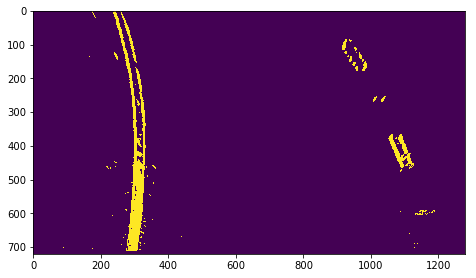

In [26]:
ksize = 5

gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(50, 200))
grady = abs_sobel_thresh(warped, orient='y', sobel_kernel=ksize, thresh=(50, 200))
mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(50, 200))
dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls = hls_select(warped, (30, 150))
hlssum = np.sum(hls)
hlssum_max=width*height
hsv = hsv_select(warped, (20, 40))

hls_mod=np.zeros_like(hls)
if hlssum < 0.1*hlssum_max:
    print("min")
    hls_mod=hls
elif hlssum > 0.9*hlssum_max:
    print("max")
    hls_mod[hls==0]=1
else:
    print("none")

combined = np.zeros_like(gradx)
combined[(gradx == 1) | (hsv == 1)] = 1

#f, ((gx, gy), (magb, dirb), (hlsb, comb), (hsvb, dummyb)) = plt.subplots(4, 2, figsize=(24, 12))
f.tight_layout()
#gx.imshow(gradx)
#gx.set_title('gradX', fontsize=25)
#gy.imshow(grady)
#gy.set_title('gradY', fontsize=25)
#magb.imshow(mag_binary)
#magb.set_title('Mag', fontsize=25)
#dirb.imshow(dir_binary)
#dirb.set_title('Dir', fontsize=25)
#hlsb.imshow(hls)
#hlsb.set_title('HLS', fontsize=25)
plt.imshow(combined)
#comb.set_title('Comb', fontsize=25)
#hsvb.imshow(hsv)
#hsvb.set_title('HSV', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#print(hlssum)
#print(np.sum(np.ones_like(gradx)))

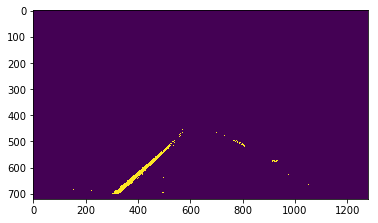

In [27]:
unwarped = cv2.warpPerspective(combined, Minv, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(unwarped)

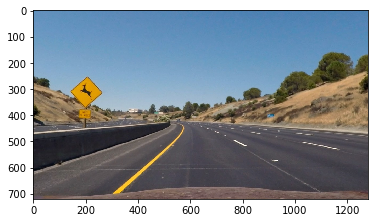

In [28]:
plt.imshow(undistorted)

0


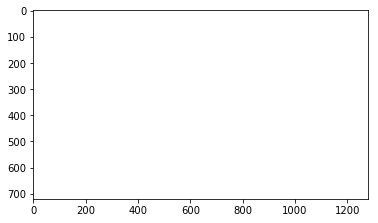

In [29]:
testimg=np.zeros_like(warped)
testimg[:,:,0]=255
testimg[:,:,1]=255
testimg[:,:,2]=255
plt.imshow(testimg)
hsv = cv2.cvtColor(testimg, cv2.COLOR_RGB2HSV)
print(hsv[0][0][0])


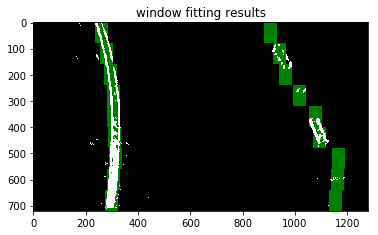

[ 301.  309.  315.  313.  308.  308.  297.  282.  263.]


In [30]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

combined*=255

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((image.shape[0]-(window_height/2), l_center,r_center))
    
    l_drift = 0
    r_drift = 0
    l_center_old = l_center
    r_center_old = r_center
    l_count=1
    r_count=1
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        if max(conv_signal[l_min_index:l_max_index]) > 40000:
            l_center_old = l_center
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            drift = l_center - l_center_old
            l_drift = (l_drift*(l_count-1) + drift)/l_count
            l_count+=1
        else:
            l_center += l_drift
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if max(conv_signal[r_min_index:r_max_index]) > 40000:
            r_center_old = r_center
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            drift = r_center - r_center_old
            r_drift = (r_drift*(r_count-1) + drift)/r_count
            r_count+=1
        else:
            r_center += r_drift
        # Add what we found for that layer
        window_centroids.append((image.shape[0]-((level+0.5)*window_height), l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(combined, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(combined)
    r_points = np.zeros_like(combined)

    # Go through each level and draw the windows    
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,combined,window_centroids[level][1],level)
        r_mask = window_mask(window_width,window_height,combined,window_centroids[level][2],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((combined,combined,combined)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((combined,combined,combined)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
window_centroids=np.array(window_centroids)
print(window_centroids[:,1])

In [31]:
ploty=window_centroids[:,0]
leftx=window_centroids[:,1]
rightx=window_centroids[:,2]
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

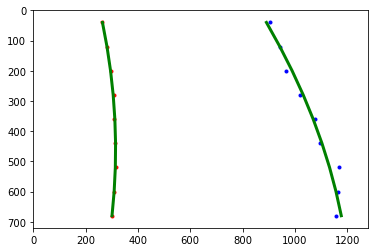

In [32]:
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis()

In [33]:
cam_center=width/2
lane_width_conversion=370/(rightx[0]-leftx[0])
lane_center=(rightx[0]+leftx[0])/2
print(cam_center)
print(lane_center)
print((cam_center-lane_center)*lane_width_conversion)

640.0
729.0
-38.4696261682


In [34]:
sz=len(ploty)
y=ploty[sz//2]
f1=(2*left_fit[0]*y)+left_fit[1]
f2=2*left_fit[0]
Rcurve_x=((1+f1**2)**1.5)/np.abs(f2)
print(Rcurve_x)

f1=(2*right_fit[0]*y)+right_fit[1]
f2=2*right_fit[0]
Rcurve_y=((1+f1**2)**1.5)/np.abs(f2)
print(Rcurve_y)

1764.40848973
1891.71902721


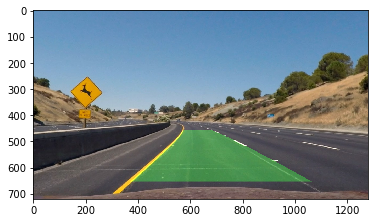

In [35]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

npts=np.int_(pts)
#npts=np.array([[(100, 200), (200, 100), (300, 400)]], dtype=np.int32)
#print(npts)
# Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, npts, (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(warp_zero, Minv, (width, height)) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
del width
del height
del undistorted
del warped
del gradx
del hsv
del combined
del window_centroids
del ploty
del leftx
del rightx

In [ ]:
def laneDetectPipeline(img):
    width=img.shape[1]
    height=img.shape[0]
    
    undistorted = cal_undistort(img, objpoints, imgpoints)
    warped = cv2.warpPerspective(undistorted, M, (width, height), flags=cv2.INTER_LINEAR)

    ksize = 5

    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(30, 150))
    hsv = hsv_select(warped, (20, 40))
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (hsv == 1)] = 1

    combined*=255
    window_centroids = find_window_centroids(combined, window_width, window_height, margin)

    if len(window_centroids) == 0:
        print("no window centroids found")
        
    window_centroids=np.array(window_centroids)
    ploty=window_centroids[:,0]
    leftx=window_centroids[:,1]
    rightx=window_centroids[:,2]
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    cam_center=width/2
    lane_width_conversion=370/(rightx[0]-leftx[0])
    lane_center=(rightx[0]+leftx[0])/2

    sz=len(ploty)
    y=ploty[sz//2]
    f1=(2*left_fit[0]*y)+left_fit[1]
    f2=2*left_fit[0]
    Rcurve_x=((1+f1**2)**1.5)/np.abs(f2)

    f1=(2*right_fit[0]*y)+right_fit[1]
    f2=2*right_fit[0]
    Rcurve_y=((1+f1**2)**1.5)/np.abs(f2)

    warp_zero = np.zeros_like(warped).astype(np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    npts=np.int_(pts)
    cv2.fillPoly(warp_zero, npts, (0,255, 0))

    newwarp = cv2.warpPerspective(warp_zero, Minv, (width, height)) 
    wimage = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return wimage


In [ ]:
def process_image(image):
    result = laneDetectPipeline(image)
    return result

In [ ]:
testimgs_dir='./test_images/'
testimgs=os.listdir(testimgs_dir)

img=mpimg.imread(testimgs_dir+testimgs[0])
lni = process_image(img)
plt.imshow(lni)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)